---

## Innovation Process and Probabilistic Triggering Function

We assume a state-space model where the innovation $(z_k)$ is defined for time instant $k$ as

$z_k = x_k - \hat{x}_{k|k-1}$

where:
- $x_k$ is the true state  
- $\hat{x}_{k|k-1}$ is the predicted state estimate  

The innovation $z_k$ is assumed to be a Gaussian random variable with variance $\sigma_{z_k}^2$ that can be determined within the Kalman update step. $z_k^*$ is a unit variance "normalized" random variable $z_k^*=z_k/\sigma_{z_k}$.

The system transmits updates based on a probabilistic trigger function $\phi_\beta(z_k^*, \alpha)$, depending on the "normalized" innovation $z_k^*=z_k/\sigma_{z_k}$ random variable $\mathcal{N}(0,1)$ and a scaling factor $\alpha$ that allows to control the likelihood of a triggering event $\gamma_k$. Having $z_k^*$ allows to model any temporal variable variance at time instant $k$, i.e., and the normalized probabilistic trigger functions is

$\phi_\beta(z_k^*, \alpha) = \exp\left( -\frac{1}{2} \left( \frac{z_k^*}{\sqrt{\alpha}} \right)^\beta \right)$.

---

In [ ]:
%pip install scipy
%pip install matplotlib

In [13]:
import numpy as np

def phi_beta(z_k, alpha, beta):
    return np.exp(-0.5 * (np.abs(z_k) / (np.sqrt(alpha)) )**beta )

---

## Event-Triggering Mechanism and (Event) Rate

The decision to trigger an event is based on a uniformly distributed random variable $U_k \sim \mathcal{U}(0, 1)$, which is compared against the trigger function

$\gamma_k =
\begin{cases}
1 & \text{if } U_k > \phi_\beta(z_k^*, \alpha), \\
0 & \text{if } U_k \leq \phi_\beta(z_k^*, \alpha).
\end{cases}$

Here:
- $\gamma_k = 1$ indicates that an update is transmitted  
- $\gamma_k = 0$ indicates that no update is transmitted

With this, a event rate $\mathbf{E}[\gamma_k]$ can be determined. Hereby, the probability of triggering an event is

$P(\gamma_k=1)=1-\phi_\beta(z_k^*,\alpha)$,

and the average event rate can be obtained by integrating the probability $P(\gamma_k)$ over the distribution of $z_k^*$. Because $z_k^*$ is a realization from $Z^*\sim \mathcal{N}(0,1)$, we can rewrite,

$\mathbf{E}[\gamma_k] = 1 - \mathbf{E}[\phi_\beta(Z^*,\alpha)]$,

or with $\varphi(z^*)$ being the standard normal pdf of $z^*$

$\mathbf{E}[\gamma_k] = 1 - \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha)\varphi(z^*)dz^*$.

---

In [14]:
from scipy.integrate import quad
from scipy.stats import norm

def event_rate(alpha, beta):
    integrand = lambda z_star: phi_beta(z_star, alpha, beta) * norm.pdf(z_star)
    return 1 - quad(integrand, -np.inf, np.inf)[0]

---

## Posterior MSE (Distortion)

The posterior MSE represents the mean squared error between the true innovation $z_k$ and the updated estimate after transmission. For $\gamma_k=1$, a full update of $z_k$ is transmitted and the RX state-space estimate is perfectly in sync with transmitted state-space, i.e., the posterior variance as the mean squared error between true and updated estimate is zero. If $\gamma_k=0$, the state estimate of the RX remains unchanged, and the error (distortion) is equal to the prio variance $\sigma_{z_k}^2$. Thus, the posterior MSE is:

$\text{MSE} = \sigma_{z_k}^2 P(\gamma_k=0)$

and since $P(\gamma_k=0)=\mathbf{E}[\phi_\beta(Z^*,\alpha)]$ the 

$\text{MSE} = \sigma_{z_k}^2 \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha) p_{Z^*}(z^*) dz^* = \sigma_{z_k}^2 \int_{-\infty}^{\infty} \phi_\beta(z^*,\alpha) \varphi(z^*) dz^* $

# Question?
Can I assume steady state KF here? so, $\sigma_{z_k} \rightarrow \sigma_z$?

---

In [15]:
def posterior_mse(alpha, beta, sigma_z2):
    return sigma_z2 * (1 - event_rate(alpha, beta))

In [16]:
# Simulation parameters
sigma_z2 = 1.0     # normalized variance of innovation

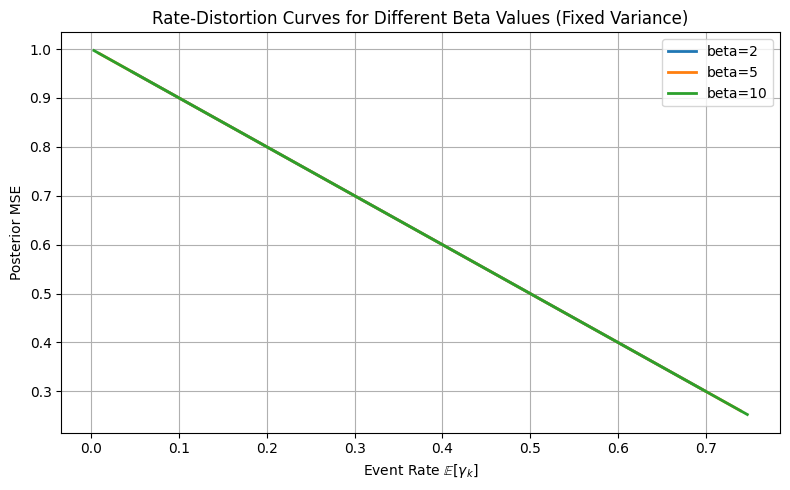

In [17]:
import matplotlib.pyplot as plt

alphas = np.linspace(1e-1, 1e1, 1000)
beta_values = [2,5,10]  # List of beta values to sweep over

plt.figure(figsize=(8, 5))

for beta in beta_values:
    rates = [event_rate(alpha, beta) for alpha in alphas]
    #mse_vals = [posterior_mse(alpha, beta, sigma_z2) for alpha in alphas]
    mse_vals = [sigma_z2 * (1-rate) for rate in rates]  # Since MSE is proportional to (1 - event_rate)
    plt.plot(rates, mse_vals, label=f'beta={beta}', lw=2)

plt.xlabel(r'Event Rate $\mathbb{E}[\gamma_k]$')
plt.ylabel('Posterior MSE')
plt.title(
    f'Rate-Distortion Curves for Different Beta Values (Fixed Variance)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

# Random Ideas

- Is this water-filling with time-varying channel gains?
- Is this power-adaptive source coding?
- Is this a fading channel rate-distortion problem?
- Isn't this a Bernoulli Erasure Encoder?
- Aren't we randomly erase Gaussian samples?
- The optimal Gaussian Rate-Distortion is $D_{opt}(R)=\sigma_z^2 2^{-2R}$ where we have $D_k=\sigma_{z_k}^2 (1 - \mathbf{E}[\gamma_k])$.
- Binary source + Erasures: $X \in {0,1}$, $X\sim Bern(1/2)$, but $\hat{X} \in {0,1,e}$ with distortion measure $0$ for correct and $1$ for wrong/erased, $D=1-R$ or $R(D)=1-D$.
- Gaussian Source + Erasures: $Z\sim \mathcal{N}(0,\sigma)$ then, "sending" perfectly means distortion $D(.)=0$ or nothing is sent $D(.)=\sigma^2$. Then if transmission probability/rate is $R$, we get $D=\sigma^2(1-R)$
- Again optimal Gaussian source coding follows: $R(D)=1/2 \log2(\frac{\sigma^2}{D})$, i.e., exponential decay in distortion, not linear decay as in $R(D)=1-\frac{D}{\sigma^2}$

# Wyner-Ziv?
For source $X$ and a correlated side information $Y$ at the decoder, that the encoder does not know, $X=Y+Z$, with $Z\sim \mathcal{N}(0,\sigma_Z^2)$ and distortion measurement $D$ evaluating the MSE, the rate-distortion function is:

$R_{WZ}(D)=\frac{1}{2}\log(\frac{\sigma_Z^2}{D})$

The important aspect with Wyner-Ziv is that there is no rate loss in not knowing $Y$ at the encoder. The connection I saw/see is:

- True state: $x_k$
- Encoder estimate: $\hat{x}_k^{Tx}$
- Decoder estimate: $\hat{x}_k^{Rx}$
- Innovation: $z_k = x_k - \hat{x}_k^{Rx}$
- Wyner-Ziv: $X = Y + Z$, where $Y=\hat{x}_k^{Rx}$ and $Z = z_k$
- The decoder has the side information $Y$ and the encoder only sends information about its innovation
- Wyner-Ziv typically achieves optimal rate/distortion metrics
- From literature we know that "zero delay Wyner-Ziv" looses all its nice properties: "The Zero-Delay Wyner-Ziv Problem" by Yonatan Kaspi and Neri Merhav (the lookahead issue they discuss, is somewhat interesting)
- Also, trigger based communication is time-sharing between, as described as optimal coding concept in "The Zero-Delay Wyner-Ziv Problem", BUT between to "maximum" fix points $(0,\sigma_z^2)$ and $(1,0)$ that is not optimal
- BUT, maybe you can get from this result WHY delay/latency is extremely costly!
- ... for coding gains we always require large block-length :-(
- Probably, https://arxiv.org/pdf/1411.7632 fits better "Semidefinite Programming Approach to Gaussian Sequential Rate-Distortion Trade-offs"

---

---

# Some Bounds from literature + simulation

with "Semidefinite Programming Approach to Gaussian Sequential Rate-Distortion Trade-offs" - and more* SRD Optimization via SDP and using a fixed $\theta$ threshold bound - one may obtain:

1) scalar linear system, all "Gaussian"

$x_{t+1} = \alpha x_t + w_t, w_t \sim \mathcal{N}(0,q), |{\alpha}|<1$

2) Transmitter KF observes $x_t$, and receiver KF gets innovation update only when predicted variance exceeds a threshold $\theta$
3) Channel is noiseless, so after a transmission, receiver error is zero:

$P_{post} = 0$

4) Event-trigger communication, iff

$P_t^- = \alpha^2 P_{t-1} + q > \theta$

5) Between two transmission the covariance grows geometrically; lets denote the number of steps between last transmission as $k=0,...,L-1$

6) after transmission, covariance

$P_0 = 0$

7) prediction step:

$P_1^-=\alpha^2 P_0 + q = q$

$P_2^-=\alpha^2 P_1^- + q = q + \alpha^2 q = a(1+\alpha^2)$

8) in general, the predicted variance grows geometrically

$P_k^- = \sum_{i=0}^{k-1} q \alpha^{2i} = q\frac{1-\alpha^{2k}}{1-\alpha^2}$

9) Transmission occurs at $L$ such that $P_l^- \ge \theta$

10) the cycle length $L$ can be drived as:

$\theta = q \frac{1-\alpha^{2L}}{1-\alpha^2} -> \rightarrow \alpha^{2L}=1-\frac{1-\alpha^2}{q}\theta$

$L(\theta) = \frac{1}{2\log(1/|\alpha|)}\log\frac{1}{1-(1-\alpha^2)\theta/q}$

11) Average distortion is time-average of receiver variance over one cycle

$D(\theta)=\frac{1}{L}\sum_{k=0}^{L-1}P_k$

12) this is geometric series:

$\sum_{k=0}^{L-1}P_k = \frac{q}{1-\alpha^2}[L-\frac{1-\alpha^{2L}}{1-\alpha^2}]$

13) such that, average distortion can be written as

$D(\theta)=\frac{q}{1-\alpha^2}-\frac{q}{L(1-\alpha^2)^2}(1-\alpha^{2L})$

14) the directed information and cycle average rate for a noiseless channel, i.e. post-update variance $P_{post}=0$ is

$I_{event}=1/2 \log \frac{P_L^-}{0} \rightarrow \infty$

15) this is bad... lets do a trick, assume tiny tiny noise $\epsilon = 1e-9$, i.e.

$R(\theta) \approx \frac{I_{event}}{L(\theta)} \approx \frac{1}{2L(\theta)}\log \frac{\theta}{\epsilon}$

16) sum up, R-D bounds (for cycle-average) is

$R(\theta) = \frac{1}{2L(\theta)}\log\frac{\theta}{\epsilon}$, $D(\theta) = \frac{q}{1-\alpha^2}-\frac{q}{L(1-\alpha^2)^2}(1-\alpha^{2L})$

17) obesrvation, $R\rightarrow \infty$ as $\theta \rightarrow 0$ (loooots of transmissions), $R\rightarrow 0$ as $\theta \rightarrow P_{\infty}$ (no transmission at all), $D \rightarrow 0$ as $\theta \rightarrow 0$ and $D\rightarrow P_{\infty}=q/(1-\alpha^2)$ as $\theta \rightarrow P_{\infty}$

*) similar work, tanaka, parrilo, mitter "semifdefine approaches to gaussian srd"; molin, hirche "event-triggered estimation performance"; martin, pappas "threshold policies for estimation over networks"; tatikonda, mitter "control und communication constraints"

---

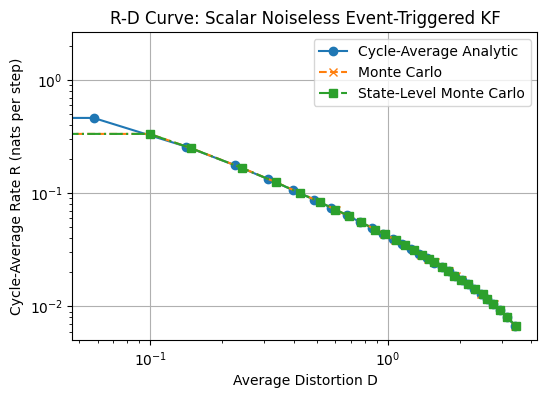

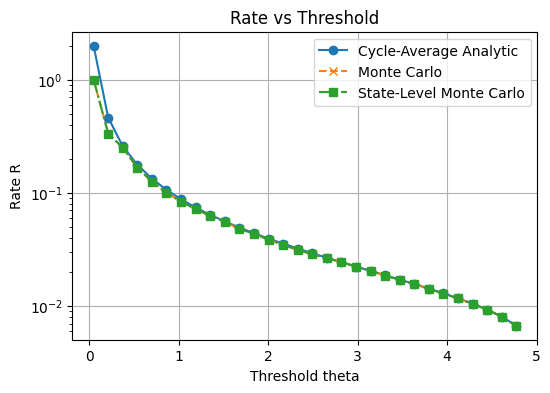

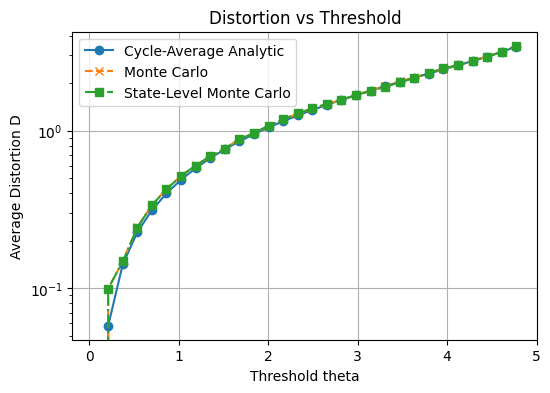

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
alpha = 0.99
q = 0.1
T = 1000000          # total time steps
burn_in = 5000      # remove transient
num_thetas = 30     # number of thresholds

P_inf = q / (1 - alpha**2)
thetas = np.linspace(0.01 * P_inf, 0.95 * P_inf, num_thetas)

# -------------------------------
# Cycle-average analytic formulas
# -------------------------------
def cycle_length(alpha, q, theta):
    L = 1 / (2 * np.log(1/abs(alpha))) * np.log(1 / (1 - (1 - alpha**2) * theta / q))
    return L

def avg_distortion(alpha, q, theta):
    L = cycle_length(alpha, q, theta)
    alpha2L = 1 - (1 - alpha**2) * theta / q
    D = (q / (1 - alpha**2)) - (q / ((1 - alpha**2)**2 * L)) * (1 - alpha2L)
    return D

def avg_rate(alpha, theta):
    L = cycle_length(alpha, q, theta)
    R = 1/L # or (1 / (2 * L)) * np.log(theta / 1e-9)  # epsilon ~ 1e-9
    return R

# -------------------------------
# Monte Carlo simulation
# -------------------------------
def simulate_RD(alpha, q, theta, T, burn_in):
    P = 0.0
    info_sum = 0.0
    num_transmissions = 0
    distortion_sum = 0.0
    count = 0

    for t in range(T):
        # Predict covariance
        P_pred = alpha**2 * P + q

        # Event-triggered transmission
        if P_pred > theta:
            info_sum += 0.5 * np.log(P_pred / 1e-9)
            num_transmissions += 1
            P_post = 0.0
        else:
            P_post = P_pred

        if t >= burn_in:
            distortion_sum += P_post
            count += 1

        P = P_post

    R_mc = num_transmissions / (T - burn_in) # or info_sum / (T - burn_in) #
    D_mc = distortion_sum / count
    return R_mc, D_mc

def realistic_monte_carlo(alpha, q, theta, T, burn_in):
    # Initialize
    x = 0.0
    x_hat_rx = 0.0  # Receiver estimate
    P_rx = 0.0
    P_rx_est = 0.0  # Transmitter's estimate of receiver's covariance
    num_transmissions = 0
    mse_sum = 0.0
    count = 0

    for t in range(T):
        # State evolution
        w = np.random.normal(0, np.sqrt(q))
        x = alpha * x + w

        # Receiver's predicted covariance (from transmitter's perspective)
        P_rx_pred = alpha**2 * P_rx_est + q

        # Event trigger based on receiver's predicted variance
        if P_rx_pred > theta:
            num_transmissions += 1
            x_hat_rx = x  # Perfect update
            P_rx = 0.0
            P_rx_est = 0.0  # Transmitter updates its estimate
        else:
            # Receiver just predicts
            x_hat_rx = alpha * x_hat_rx
            P_rx = alpha**2 * P_rx + q
            P_rx_est = P_rx_pred  # Transmitter updates its estimate

        if t >= burn_in:
            mse_sum += (x - x_hat_rx)**2
            count += 1

    R_mc = num_transmissions / (T - burn_in)
    D_mc = mse_sum / count
    return R_mc, D_mc

# -------------------------------
# Compute curves
# -------------------------------
R_cycle = []
D_cycle = []

R_mc = []
D_mc = []

R_mc_real = []
D_mc_real = []
for theta in thetas:
    R_cycle.append(avg_rate(alpha, theta))
    D_cycle.append(avg_distortion(alpha, q, theta))
    Rm, Dm = simulate_RD(alpha, q, theta, T, burn_in)
    R_mc.append(Rm)
    D_mc.append(Dm)
    Rr, Dr = realistic_monte_carlo(alpha, q, theta, T, burn_in)
    R_mc_real.append(Rr)
    D_mc_real.append(Dr)

# -------------------------------
# Plot R-D curve
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(D_cycle, R_cycle, label='Cycle-Average Analytic', marker='o')
plt.plot(D_mc, R_mc, '--', label='Monte Carlo', marker='x')
plt.plot(D_mc_real, R_mc_real, '-.', label='State-Level Monte Carlo', marker='s')
plt.xlabel("Average Distortion D")
plt.xscale('log')
plt.ylabel("Cycle-Average Rate R (nats per step)")
plt.yscale('log')
plt.title("R-D Curve: Scalar Noiseless Event-Triggered KF")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Plot Rate vs Threshold
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(thetas, R_cycle, label='Cycle-Average Analytic', marker='o')
plt.plot(thetas, R_mc, '--', label='Monte Carlo', marker='x')
plt.plot(thetas, R_mc_real, '-.', label='State-Level Monte Carlo', marker='s')
plt.xlabel("Threshold theta")
plt.ylabel("Rate R")
plt.yscale('log')
plt.title("Rate vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# Plot Distortion vs Threshold
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(thetas, D_cycle, label='Cycle-Average Analytic', marker='o')
plt.plot(thetas, D_mc, '--', label='Monte Carlo', marker='x')
plt.plot(thetas, D_mc_real, '-.', label='State-Level Monte Carlo', marker='s')
plt.xlabel("Threshold theta")
plt.ylabel("Average Distortion D")
plt.yscale('log')
plt.title("Distortion vs Threshold")
plt.legend()
plt.grid(True)
plt.show()